In [1389]:
#pip install category_encoders
#pip install pygini
#pip install feature_engine
#pip install scikit-optimize 

import pandas as pd
import seaborn as sns
import numpy as np
import math
import re
import sklearn
from numpy import percentile
from scipy.stats import ks_2samp, kstest
from matplotlib import pyplot as plt
from feature_engine.encoding import RareLabelEncoder
from category_encoders.woe import WOEEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from pygini import gini
from skopt import BayesSearchCV
from pandas import get_dummies
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

import warnings

In [1390]:
def data_outlier(data):
    """Функция определяет выбросы признаков и строит датафрейм"""

    data_out = pd.DataFrame(data={'name': [], 'нижняя граница': [], 'верхняя граница': [], 'количество выбросов': []})
    
    df_copy = data.copy()
    numeric_f = df_copy.select_dtypes(include=['int64', 'float64']).columns.drop(['Credit Default']).to_list()
    
    for column in numeric_f:
        perc25 = percentile(df_copy[column].dropna(axis=0), 25)
        perc75 = percentile(df_copy[column].dropna(axis=0), 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df_copy.loc[((df_copy[column] < low_range) | 
                                 (df_copy[column] > upper_range)), column].count()

        to_append = [column, round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append

    data_out = data_out.set_index('name')

    return data_out

In [1391]:
def count_plot(var, data):
    plt.figure(figsize=(5,7))
    sns.countplot(y=var, data=data, hue='Credit Default', order=data[var].value_counts().index)
    plt.show()

In [1392]:
def hist_plot(var, data):

    plt.figure(figsize=(15,5))
    sns.histplot(x=var, data=data, hue='Credit Default', multiple="stack")
    plt.show()  
    
    #Создаем логарифмическую переменную от исходной если количетсво уникальных значений больше 100
    if data[var].nunique() > 100:
        data_copy = data[[var, 'Credit Default']].copy()
        var_log = var +'_log'
        data_copy[var_log] = np.log(data_copy[var] + 1)
        
        plt.figure(figsize=(15,5))
        sns.histplot(x=var_log, data=data_copy, hue='Credit Default', multiple="stack")
        plt.show() 

In [1393]:
# интервальный Джини
def interval_gini_old(prb_list):
    """Функция считает значение Джини на 1000 бустреп выборках из 100 элементов и записывает значения в список"""
    gini_values = []
    
    for x in range(1000):
        gini_x = gini(np.random.choice(prb_list, size=100))
        gini_values.append(gini_x)
    
    return gini_values

In [1394]:
def interval_gini(y_test, model_prb):
    """Функция считает значение Джини на 1000 бустреп выборках из 100 элементов и записывает значения в список"""
    gini_values = []
    
    for x in range(1000):
        list_index = np.random.randint(len(y_test), size=100)
        roc_auc_val = roc_auc_score(y_test.values[list_index], lr_prb[list_index])
        gini_x = 2 * roc_auc_val - 1
        gini_values.append(gini_x)
    
    return gini_values


In [1395]:
# КС тест
def model_ks_test(model_prb, data):
    """Функция строит распределение кумулятивной функции скоринга и выводит значение тест КС"""
    
    data_copy = pd.DataFrame(zip(data['Credit Score'],model_prb), columns=['Scoring', 'probab_default'])
    data_copy['default'] = data_copy['probab_default'].apply(lambda x: 1 if x >= 0.5 else 0)
    
    good_clients = data_copy.loc[(data_copy['default']==0), 'Scoring'].value_counts().sort_index()
    bad_clients = data_copy.loc[(data_copy['default']==1), 'Scoring'].value_counts().sort_index()
    
    scoring_list = []
    for x in range(400, 1000):
        scoring_list.append([x, good_clients.get(x, 0), bad_clients.get(x, 0)])
    
    df_scoring = pd.DataFrame(scoring_list, columns=['Scoring', 'good_count', 'bad_count'])
    df_scoring['good_cumsum'] = np.cumsum(df_scoring['good_count'])
    df_scoring['bad_cumsum'] = np.cumsum(df_scoring['bad_count'])   
    df_scoring['good_cumsum_perc'] = round(df_scoring['good_cumsum'] / df_scoring['good_count'].sum() * 100, 2)
    df_scoring['bad_cumsum_perc'] = round(df_scoring['bad_cumsum'] / df_scoring['bad_count'].sum() * 100, 2)
    
    plt.figure(figsize=(10,5))
    sns.lineplot(data=df_scoring, x='Scoring', y='good_cumsum_perc')
    sns.lineplot(data=df_scoring, x='Scoring', y='bad_cumsum_perc')
    plt.show()
    
    return ks_2samp(df_scoring['good_cumsum_perc'], df_scoring['bad_cumsum_perc'])

In [1396]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [1397]:
def model_calibr_curve(model_name, model_prb, y_test, X_val, y_val):
    """Функция считает изотоническую калибровку для модели и выводит график сравнения"""

    #IsotonicRegression
    isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(model_prb, y_test)
    prb_isotonic_regress = isotonic_regress.predict(model_name.predict_proba(X_val)[:, 1])

    #Создаем calibration_curve для моделей для сравнения
    prob_true_model, prob_pred_model = calibration_curve(y_test, model_prb, n_bins=10)
    prob_true_iso, prob_pred_iso = calibration_curve(y_val, prb_isotonic_regress, n_bins=10)
    
    #Строим график
    plt.figure(figsize=(7,7))
    plt.plot([0,1], [0,1], color='grey')
    plt.plot(prob_pred_model, prob_true_model, marker='o', label=model_name)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='iso_model')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability in each bin')
    plt.show()

In [1398]:
warnings.simplefilter("ignore")
RANDOM_SEED = 42

In [1399]:
df = pd.read_csv('C:/Users/Files/GB_AA_DataScience/AA_test/train.csv')

In [1400]:
df.sample(10)

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7435,7435,Home Mortgage,NaN,5 years,0.0,4.0,26.9,314380.0,0.0,NaN,0.0,debt consolidation,Short Term,168476.0,61351.0,12474.0,NaN,0
4904,4904,Own Home,1605158.0,< 1 year,0.0,15.0,13.5,590370.0,0.0,18.0,0.0,debt consolidation,Long Term,306130.0,271757.0,18192.0,714.0,0
6146,6146,Rent,876717.0,2 years,0.0,6.0,15.4,238392.0,1.0,NaN,1.0,debt consolidation,Short Term,187572.0,133627.0,10301.0,738.0,0
3837,3837,Home Mortgage,NaN,4 years,0.0,7.0,15.8,610346.0,0.0,NaN,0.0,medical bills,Long Term,215996.0,117021.0,19198.0,NaN,0
4754,4754,Rent,NaN,10+ years,0.0,16.0,21.1,1113024.0,0.0,NaN,0.0,debt consolidation,Long Term,529122.0,745921.0,29193.0,NaN,1
3777,3777,Home Mortgage,936985.0,10+ years,0.0,12.0,14.4,617804.0,0.0,26.0,0.0,debt consolidation,Short Term,175758.0,125381.0,13196.0,736.0,0
3155,3155,Rent,NaN,9 years,0.0,24.0,21.0,677160.0,0.0,12.0,0.0,business loan,Short Term,399674.0,331588.0,23300.0,NaN,0
6425,6425,Rent,1587545.0,7 years,0.0,10.0,13.5,367774.0,0.0,43.0,0.0,debt consolidation,Long Term,216260.0,173090.0,23152.0,658.0,0
283,283,Home Mortgage,706268.0,5 years,0.0,4.0,14.3,129096.0,0.0,20.0,0.0,debt consolidation,Short Term,172172.0,96881.0,3102.0,728.0,0
2282,2282,Own Home,597417.0,7 years,0.0,13.0,16.8,419892.0,0.0,25.0,0.0,debt consolidation,Short Term,99999999.0,151582.0,13541.0,735.0,0


In [1401]:
df.shape

(7500, 18)

In [1402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [1403]:
df.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [1404]:
# Посмотрим количество уникальных значений
df.nunique()

Id                              7500
Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

### Обработка NULL значений

In [1405]:
df.shape

(7500, 18)

In [1406]:
# Обработка null значений
print("Доля NULL значений у признаков")
round(df.isna().sum() / df.shape[0] * 100, 4)

Доля NULL значений у признаков


Id                               0.0000
Home Ownership                   0.0000
Annual Income                   20.7600
Years in current job             4.9467
Tax Liens                        0.0000
Number of Open Accounts          0.0000
Years of Credit History          0.0000
Maximum Open Credit              0.0000
Number of Credit Problems        0.0000
Months since last delinquent    54.4133
Bankruptcies                     0.1867
Purpose                          0.0000
Term                             0.0000
Current Loan Amount              0.0000
Current Credit Balance           0.0000
Monthly Debt                     0.0000
Credit Score                    20.7600
Credit Default                   0.0000
dtype: float64

Видим, что осталось много записей с NULL у Months since last delinquent. 
Скорее всего это люди, у которых не было нарушений. Выделим новый признак.

In [1407]:
df[df['Annual Income'].isna()].isna().sum()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job              75
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent     874
Bankruptcies                       2
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Видим, что много записей у других атрибутов, где Annual Income is NULL. Не имеет смысла заменять эти записи. Удалим их

In [1408]:
df = df[df['Annual Income'].isna()==False]

In [1409]:
df.isna().sum()

Id                                 0
Home Ownership                     0
Annual Income                      0
Years in current job             296
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    3207
Bankruptcies                      12
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
dtype: int64

Также есть записи с NULL у Years in current job и Bankruptcies. Их немного, сделаем замену.

In [1410]:
#Заполним категориальные признаки самыми популярным
df['Years in current job'].fillna(df['Years in current job'].value_counts().index[0], inplace=True)
df['Bankruptcies'].fillna(df['Bankruptcies'].value_counts().index[0], inplace=True)

#Создадим новый атрибут 'Without delinquent' и заполним старый атрибут 0
df['Without delinquent'] = df['Months since last delinquent'].apply(lambda x: 1 if pd.isna(x) else 0)
df['Months since last delinquent'].fillna(0, inplace=True)

## Рассмотрим все признаки

Распределим признаки начально на бинарные, категориальные и числовые

Признак id не рассматриваем, удалим его

### Категориальные признаки

#### Home Ownership

In [1411]:
print("Тип атрибута:", df['Home Ownership'].dtype) 
print("Количество незаполненных значений:", 
      df.loc[(df['Home Ownership']==''), 'Home Ownership'].count())

Тип атрибута: object
Количество незаполненных значений: 0


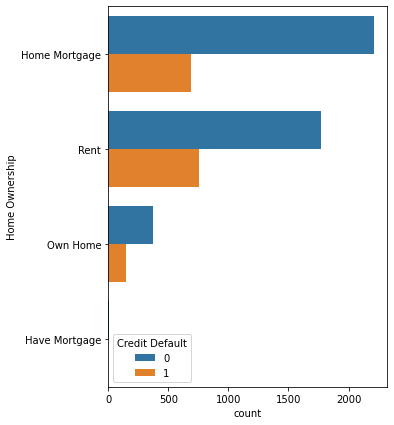

In [1412]:
count_plot('Home Ownership', df)

In [1413]:
df.loc[df['Home Ownership']=='Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

Так как количество значений 'Have Mortgage' слишком мало, указали ему похожее значение 'Home Mortgage'

#### Years in current job

In [1414]:
print("Тип атрибута:", df['Years in current job'].dtype) 
print("Количество незаполненных значений:", 
      df.loc[(df['Years in current job']==''), 'Years in current job'].count())

Тип атрибута: object
Количество незаполненных значений: 0


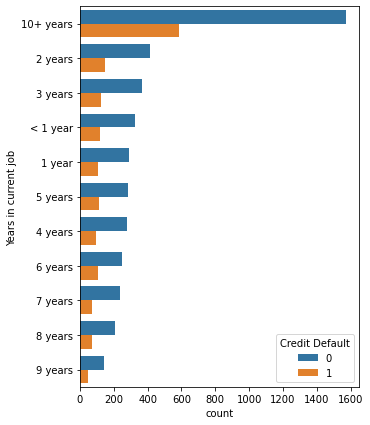

In [1415]:
count_plot('Years in current job', df)

Сделаем преобразование и поменяем тип данных

In [1416]:
df.loc[(df['Years in current job']=='< 1 year'), 'Years in current job'] = '0 year' 
df['Years in current job'] = df['Years in current job'].str.extract(r'(\d+)')

In [1417]:
df['Years in current job'] = df['Years in current job'].astype('int64') + 1

#### Term

In [1418]:
print("Тип атрибута:", df['Term'].dtype) 
print("Количество незаполненных значений:", df.loc[(df['Term']==''), 'Term'].count())

Тип атрибута: object
Количество незаполненных значений: 0


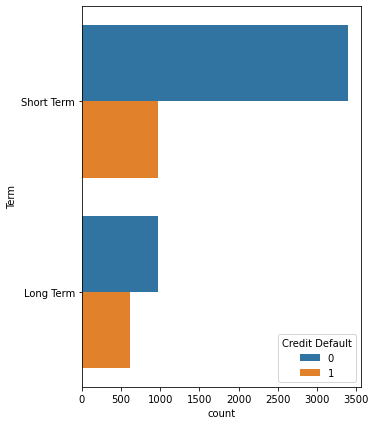

In [1419]:
count_plot('Term', df)

#### Purpose 

In [1420]:
print("Тип атрибута:", df['Purpose'].dtype) 
print("Количество незаполненных значений:", df.loc[(df['Purpose']==''), 'Purpose'].count())

Тип атрибута: object
Количество незаполненных значений: 0


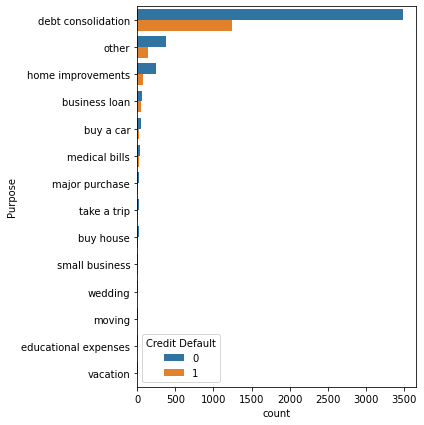

In [1421]:
count_plot('Purpose', df)

Вывод: с помощью rare-encoder объединим редкие значения в одну группу

### Числовые признаки

In [1422]:
#Создадим датафреим, показывающий значение выбросов числовых признаков
data_out = data_outlier(df)
data_out

,нижняя граница,верхняя граница,количество выбросов
name,,,
Id,-3686.75,11223.25,0.0
Annual Income,-349353.00,2833831.00,287.0
Years in current job,-6.50,21.50,0.0
Tax Liens,0.00,0.00,106.0
Number of Open Accounts,-1.00,23.00,138.0
Years of Credit History,1.05,34.25,181.0
Maximum Open Credit,-494670.00,1565762.00,370.0
Number of Credit Problems,0.00,0.00,816.0
Months since last delinquent,-43.50,72.50,182.0


#### Tax Liens

In [1423]:
print("Тип атрибута:", df['Tax Liens'].dtype) 
print("Количество уникальных значений:", df['Tax Liens'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Tax Liens'])

Тип атрибута: float64
Количество уникальных значений: 8

Данные по выбросам:
нижняя граница           0.0
верхняя граница          0.0
количество выбросов    106.0
Name: Tax Liens, dtype: float64


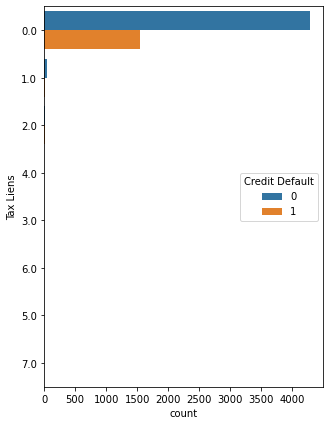

In [1424]:
count_plot('Tax Liens', df)

Вывод: Значение 0 имеет сильное преобладание над остальными значениями. Удалим атрибут

In [1425]:
df = df.drop('Tax Liens', axis=1)

#### Number of Credit Problems

In [1426]:
print("Тип атрибута:", df['Number of Credit Problems'].dtype)
print("Количество уникальных значений:", df['Number of Credit Problems'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Number of Credit Problems'])

Тип атрибута: float64
Количество уникальных значений: 8

Данные по выбросам:
нижняя граница           0.0
верхняя граница          0.0
количество выбросов    816.0
Name: Number of Credit Problems, dtype: float64


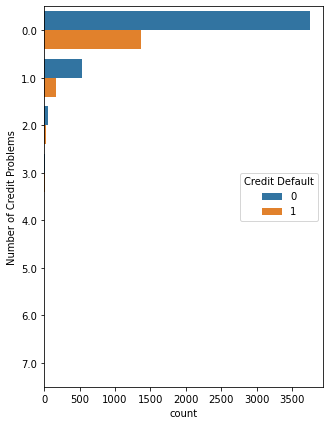

In [1427]:
count_plot('Number of Credit Problems', df)

In [1428]:
df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('object') 

Вывод: изменили тип атрибута на object, с помощью rare-encoder объединим редкие значения в одну группу

#### Bankruptcies

In [1429]:
print("Тип атрибута:", df['Bankruptcies'].dtype)
print("Количество уникальных значений:", df['Bankruptcies'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Bankruptcies'])

Тип атрибута: float64
Количество уникальных значений: 5

Данные по выбросам:
нижняя граница           0.0
верхняя граница          0.0
количество выбросов    654.0
Name: Bankruptcies, dtype: float64


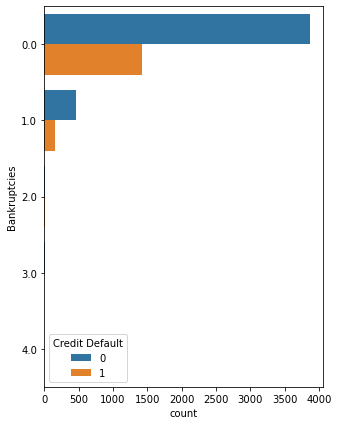

In [1430]:
count_plot('Bankruptcies', df)

In [1431]:
df['Bankruptcies'] = df['Bankruptcies'].astype('object') 

Вывод: изменили тип атрибута на object, с помощью rare-encoder объединим редкие значения в одну группу

#### Annual Income

In [1432]:
print("Тип атрибута:", df['Annual Income'].dtype)
print("Количество уникальных значений:", df['Annual Income'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Annual Income'])

Тип атрибута: float64
Количество уникальных значений: 5478

Данные по выбросам:
нижняя граница         -349353.0
верхняя граница        2833831.0
количество выбросов        287.0
Name: Annual Income, dtype: float64


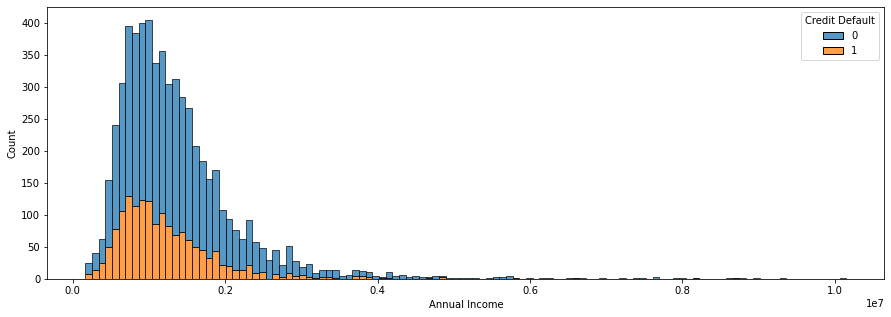

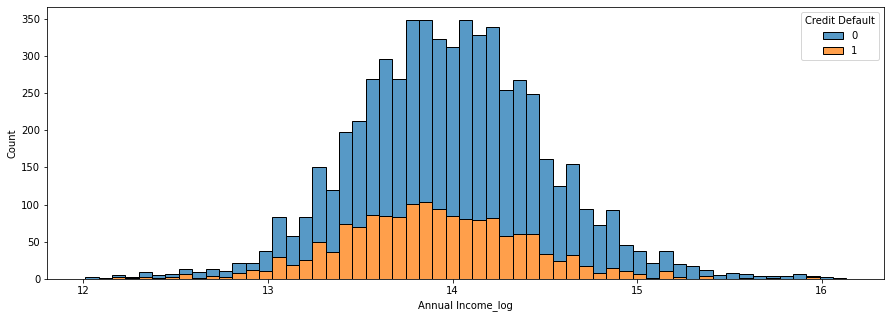

In [1433]:
hist_plot('Annual Income', df)

In [1434]:
df['Annual Income log'] = np.log(df['Annual Income'] + 1)

Вывод: Добавили новый признак с логарифмом

#### Number of Open Accounts

In [1435]:
print("Тип атрибута:", df['Number of Open Accounts'].dtype)
print("Количество уникальных значений:", df['Number of Open Accounts'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Number of Open Accounts'])

Тип атрибута: float64
Количество уникальных значений: 39

Данные по выбросам:
нижняя граница          -1.0
верхняя граница         23.0
количество выбросов    138.0
Name: Number of Open Accounts, dtype: float64


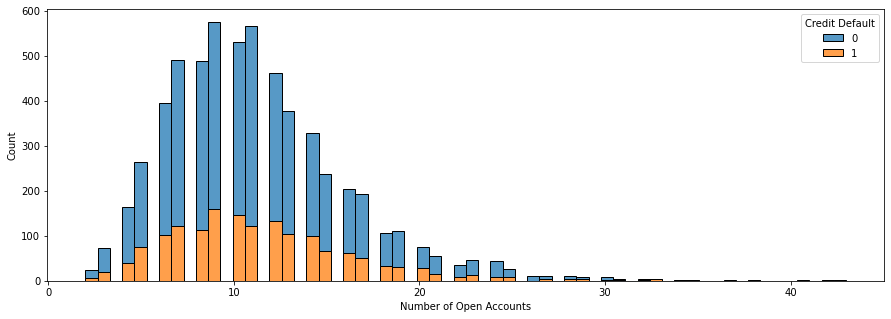

In [1436]:
hist_plot('Number of Open Accounts', df)

In [1437]:
df['Open Accounts bins'] = pd.qcut(df['Number of Open Accounts'], q=[0, .2, .4, .6, .8, 1], 
                                  labels=["bin1", "bin2", "bin3", "bin4", "bin5"]).astype('object')

Вывод: сделали разбиение на бины, изменить тип данных, с помощью rare-encoder объединим редкие группы в одну

#### Years of Credit History

In [1438]:
print("Тип атрибута:", df['Years of Credit History'].dtype)
print("Количество уникальных значений:", df['Years of Credit History'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Years of Credit History'])

Тип атрибута: float64
Количество уникальных значений: 393

Данные по выбросам:
нижняя граница           1.05
верхняя граница         34.25
количество выбросов    181.00
Name: Years of Credit History, dtype: float64


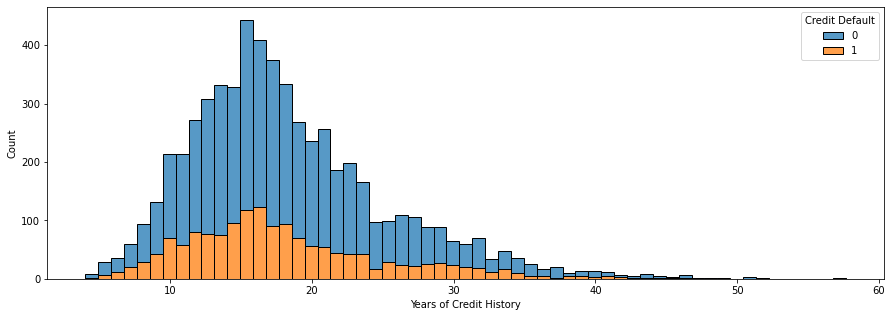

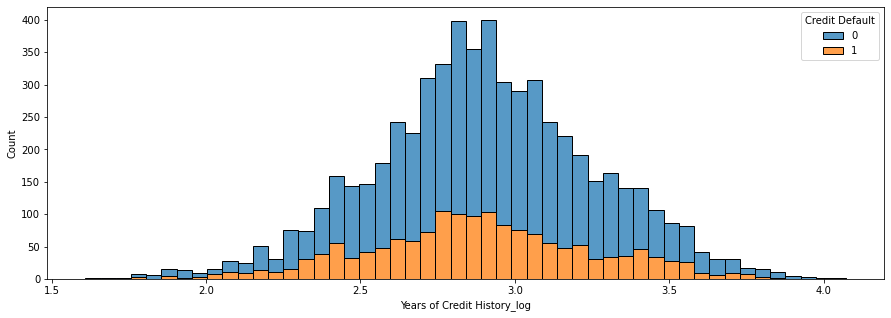

In [1439]:
hist_plot('Years of Credit History', df)

In [1440]:
df['Years of Credit History log'] = np.log(df['Years of Credit History'] + 1)

Cделаем новый признак логарифмированием

#### Maximum Open Credit

In [1441]:
print("Тип атрибута:", df['Maximum Open Credit'].dtype)
print("Количество уникальных значений:", df['Maximum Open Credit'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Maximum Open Credit'])

Тип атрибута: float64
Количество уникальных значений: 5587

Данные по выбросам:
нижняя граница         -494670.0
верхняя граница        1565762.0
количество выбросов        370.0
Name: Maximum Open Credit, dtype: float64


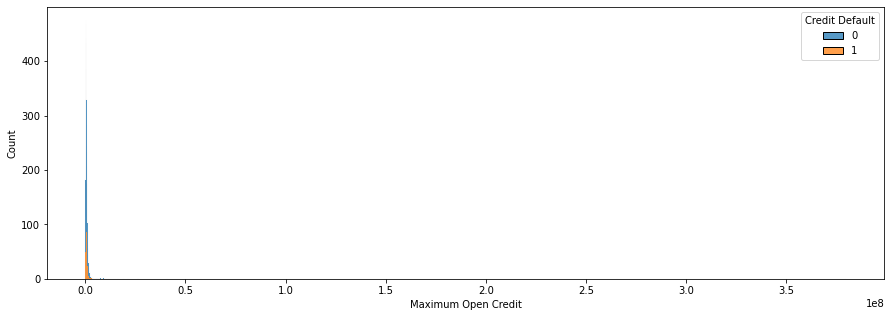

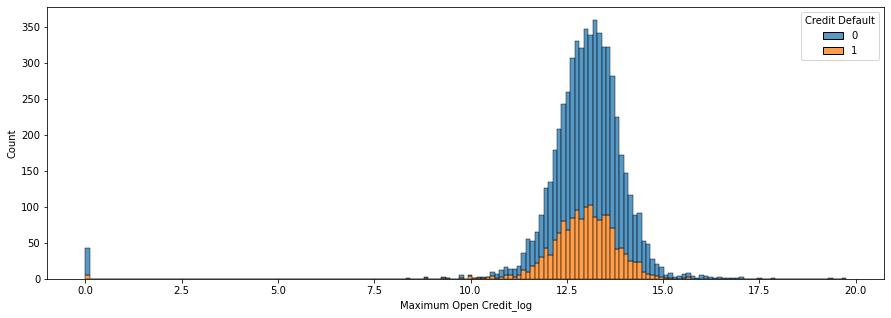

In [1442]:
hist_plot('Maximum Open Credit', df)

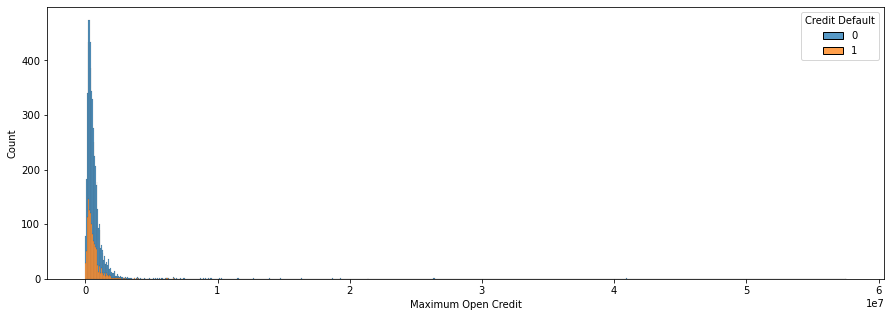

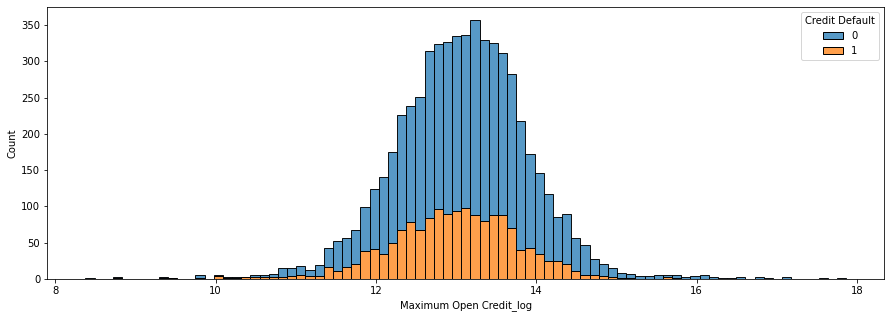

In [1443]:
#Посмотрим распределение по значениям больше 0 и меньше 100_000_000
hist_plot('Maximum Open Credit', df[(df['Maximum Open Credit']>0) & (df['Maximum Open Credit']<100_000_000)])

In [1444]:
df = df[(df['Maximum Open Credit']>0) & (df['Maximum Open Credit']<100_000_000)]

In [1445]:
df['Maximum Open Credit log'] = np.log(df['Maximum Open Credit'] + 1)

Вывод: обрезали явный выброс и создадим новый признак логарифмированием исходного признака без 0-ых значений

#### Months since last delinquent

In [1446]:
print("Тип атрибута:", df['Months since last delinquent'].dtype)
print("Количество уникальных значений:", df['Months since last delinquent'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Months since last delinquent'])

Тип атрибута: float64
Количество уникальных значений: 89

Данные по выбросам:
нижняя граница         -43.5
верхняя граница         72.5
количество выбросов    182.0
Name: Months since last delinquent, dtype: float64


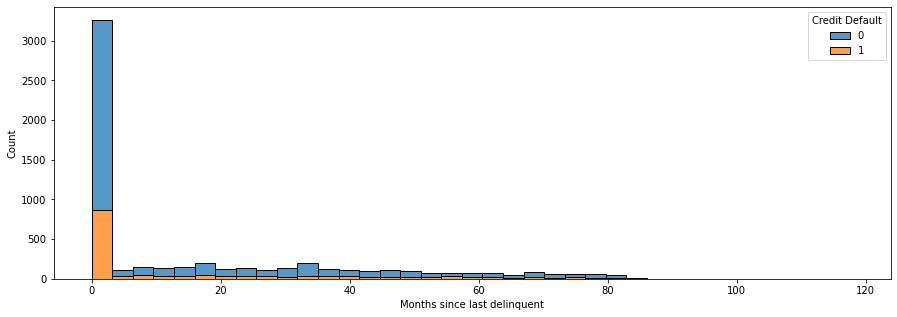

In [1447]:
hist_plot('Months since last delinquent', df)

Вывод: возможно лучше удалить атрибут

In [1448]:
df = df.drop('Months since last delinquent', axis=1)

#### Current Loan Amount

In [1449]:
print("Тип атрибута:", df['Current Loan Amount'].dtype)
print("Количество уникальных значений:", df['Current Loan Amount'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Current Loan Amount'])

Тип атрибута: float64
Количество уникальных значений: 4288

Данные по выбросам:
нижняя граница         -348183.0
верхняя граница        1083313.0
количество выбросов        870.0
Name: Current Loan Amount, dtype: float64


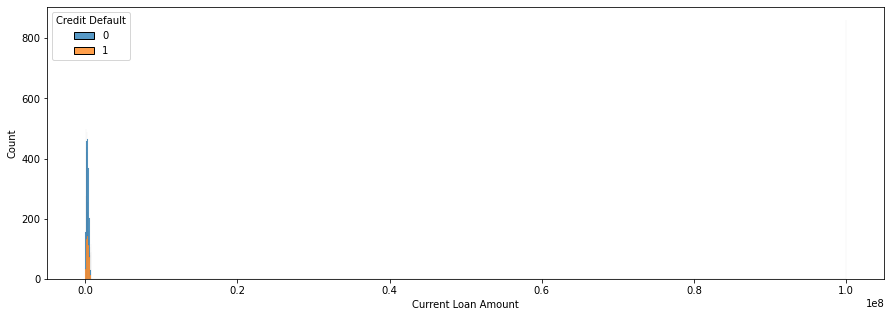

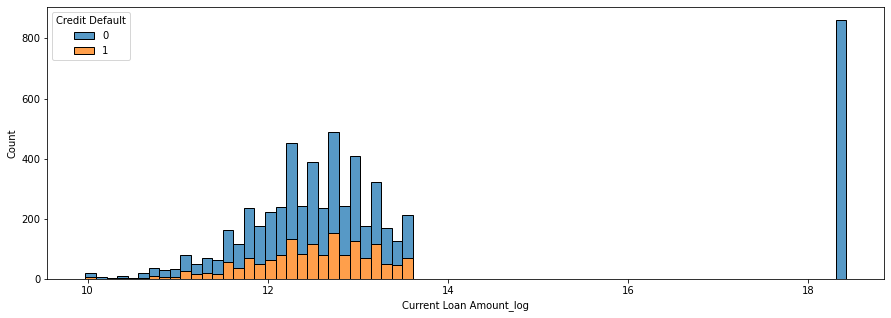

In [1450]:
hist_plot('Current Loan Amount', df)

Так как часть значений 99999999.0 (возможно это заглушка), ставим посмотрим распределение < 99_999_999

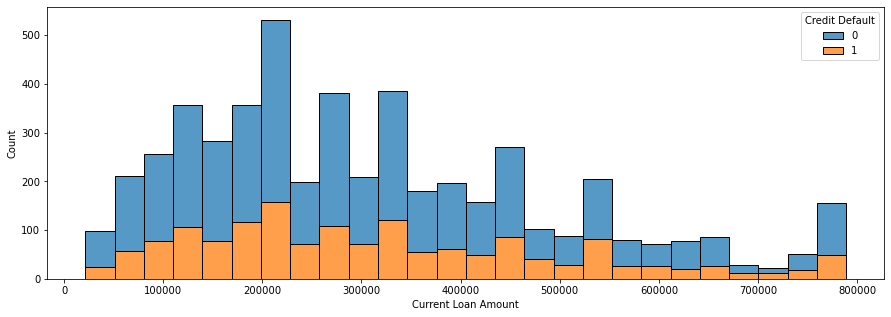

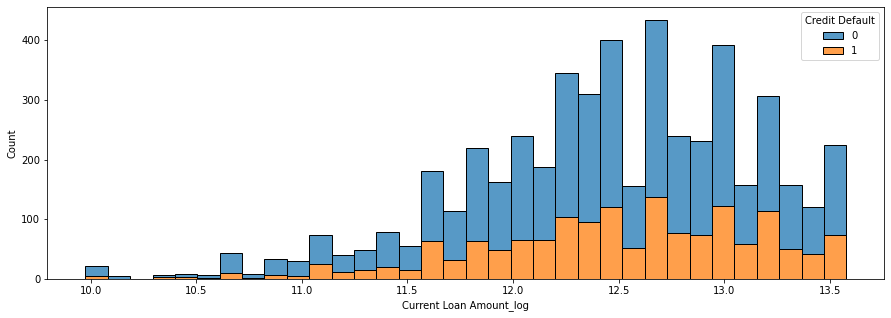

In [1451]:
hist_plot('Current Loan Amount', df[df['Current Loan Amount'] < 99_999_999])

In [1452]:
df = df[df['Current Loan Amount'] < 99_999_999]

Вывод: Обрезали признак по значению заглушки

#### Current Credit Balance

In [1453]:
print("Тип атрибута:", df['Current Credit Balance'].dtype)
print("Количество уникальных значений:", df['Current Credit Balance'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Current Credit Balance'])

Тип атрибута: float64
Количество уникальных значений: 4631

Данные по выбросам:
нижняя граница        -256229.25
верхняя граница        732036.75
количество выбросов       338.00
Name: Current Credit Balance, dtype: float64


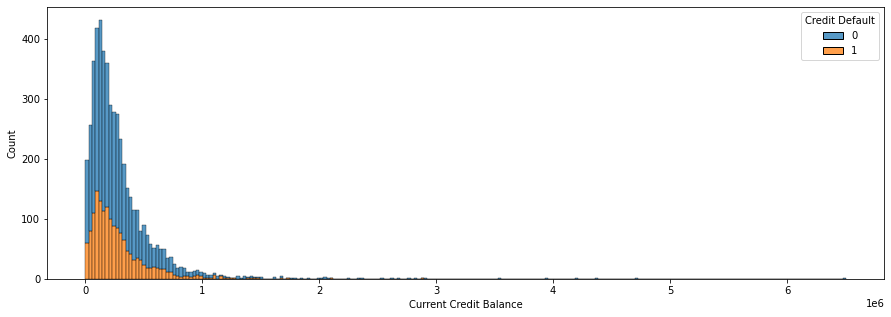

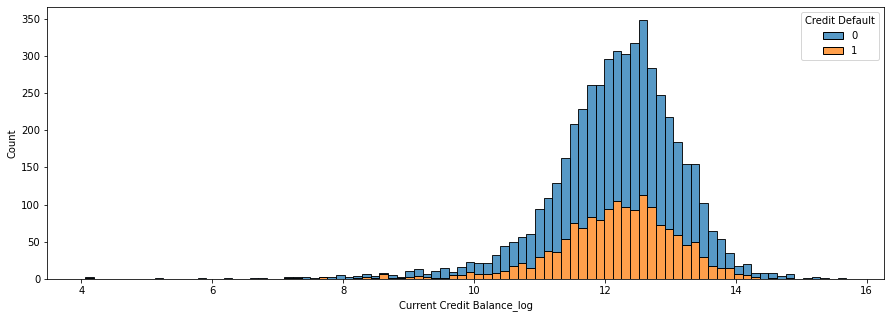

In [1454]:
hist_plot('Current Credit Balance', df)

In [1455]:
df['Current Credit Balance log'] = np.log(df['Current Credit Balance'] + 1)

Создали новый признак логарифмированием

#### Monthly Debt

In [1456]:
print("Тип атрибута:", df['Monthly Debt'].dtype)
print("Количество уникальных значений:", df['Monthly Debt'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Monthly Debt'])

Тип атрибута: float64
Количество уникальных значений: 4661

Данные по выбросам:
нижняя граница        -10521.25
верхняя граница        44380.75
количество выбросов      192.00
Name: Monthly Debt, dtype: float64


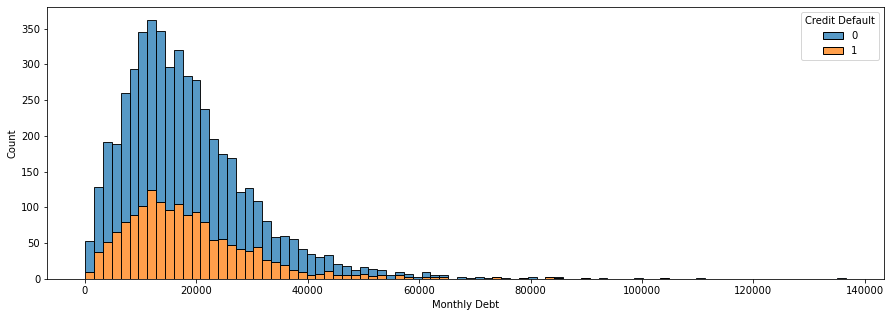

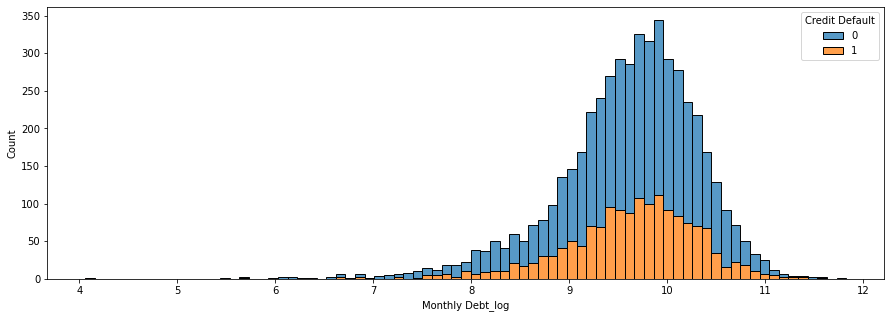

In [1457]:
hist_plot('Monthly Debt', df)

In [1458]:
df['Monthly Debt log'] = np.log(df['Monthly Debt'] + 1)

Вывод: Создали новый признак логарифмированием

#### Credit Score

In [1459]:
print("Тип атрибута:", df['Credit Score'].dtype)
print("Количество уникальных значений:", df['Credit Score'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Credit Score'])

Тип атрибута: float64
Количество уникальных значений: 266

Данные по выбросам:
нижняя граница         663.0
верхняя граница        791.0
количество выбросов    662.0
Name: Credit Score, dtype: float64


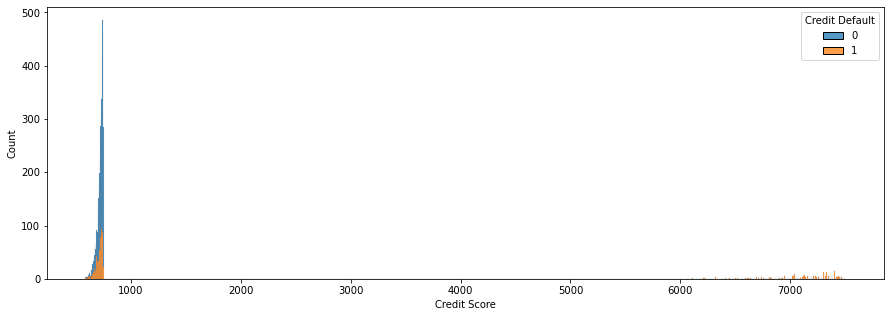

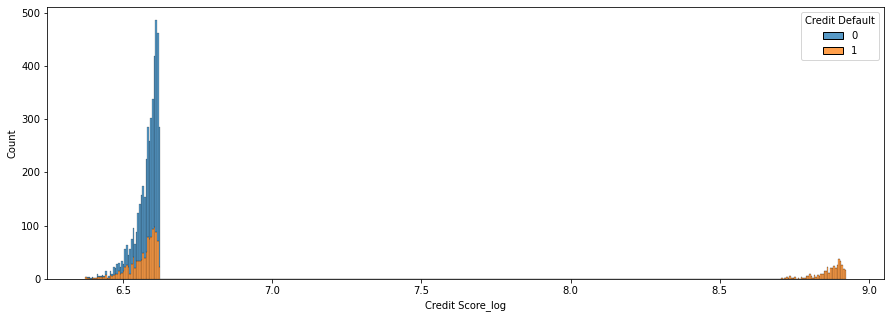

In [1460]:
hist_plot('Credit Score', df)

Посмотрим, как распределены значения дефолта у скоров больше 6000

In [1461]:
df.loc[(df['Credit Score'] >= 6000),'Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

Часть скоров имеет значение > 6000. Скорее всего это ошибка в вычислении скора 
(она может быть не более 1000, и чем больше скор, тем лучше занчение дефолта должно быть, а у всех записей значение дефолта = 1.
Возможно, сделать преобразвоание, либо просто удалить строки (их не так много)

In [1462]:
# Удалим строки со скором >= 6000
#df = df[df['Credit Score'] < 6000]
df['Credit Score'] = df['Credit Score'].apply(lambda x: x/10 if x>=6000 else x).astype('int64')

#### Таргет Credit Default

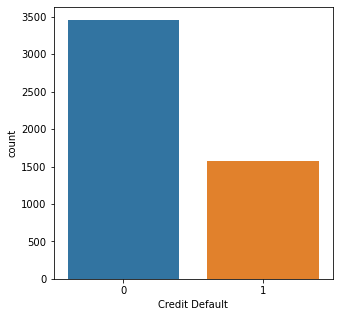

In [1463]:
plt.figure(figsize=(5,5))
sns.countplot(x='Credit Default', data=df)
plt.show()

### Создадим новые признаки

In [1464]:
df['Monthly Debt allow'] = round(df['Annual Income'] / df['Monthly Debt'], 3)

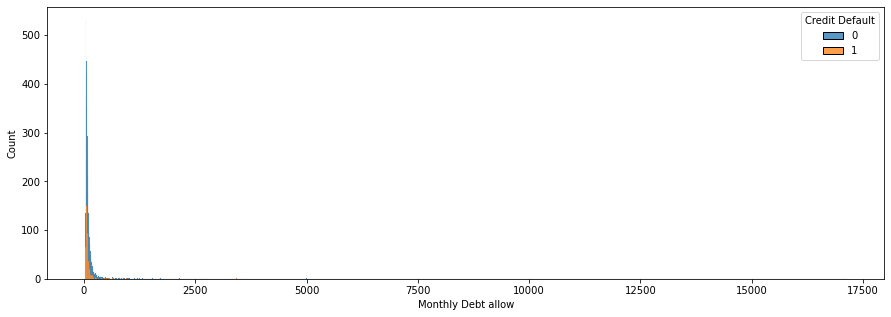

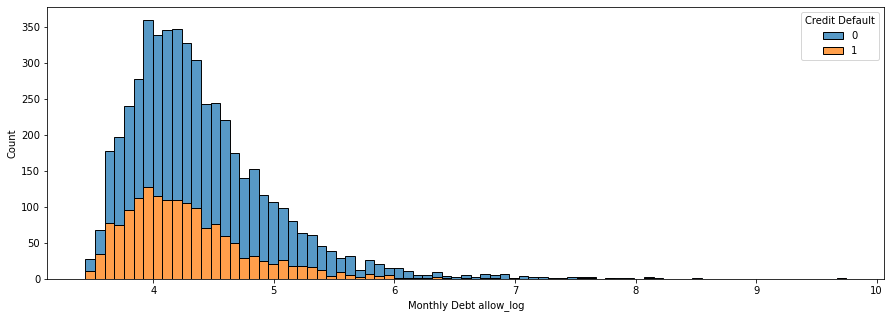

In [1465]:
hist_plot('Monthly Debt allow', df)

In [1466]:
df['Monthly Debt allow log'] = np.log(df['Monthly Debt allow'] + 1)

In [1467]:
df['years allow'] = round(df['Annual Income'] / df['Years in current job'], 3)

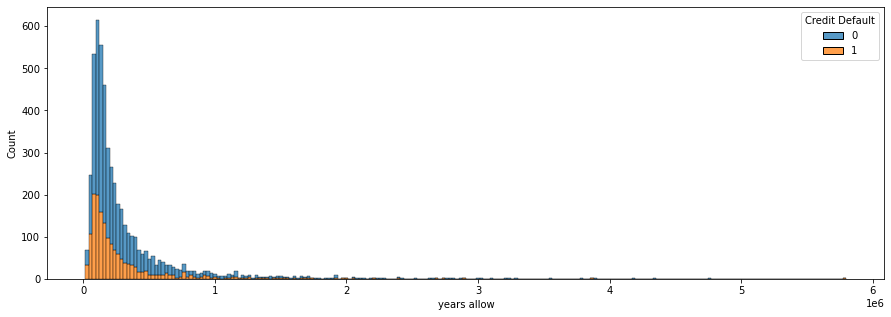

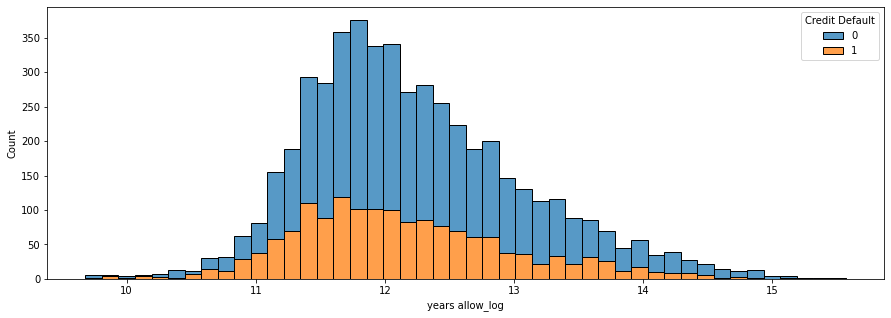

In [1468]:
hist_plot('years allow', df)

In [1469]:
df['years allow log'] = np.log(df['years allow'] + 1)

## Работа с признаками

### Корреляция признаков

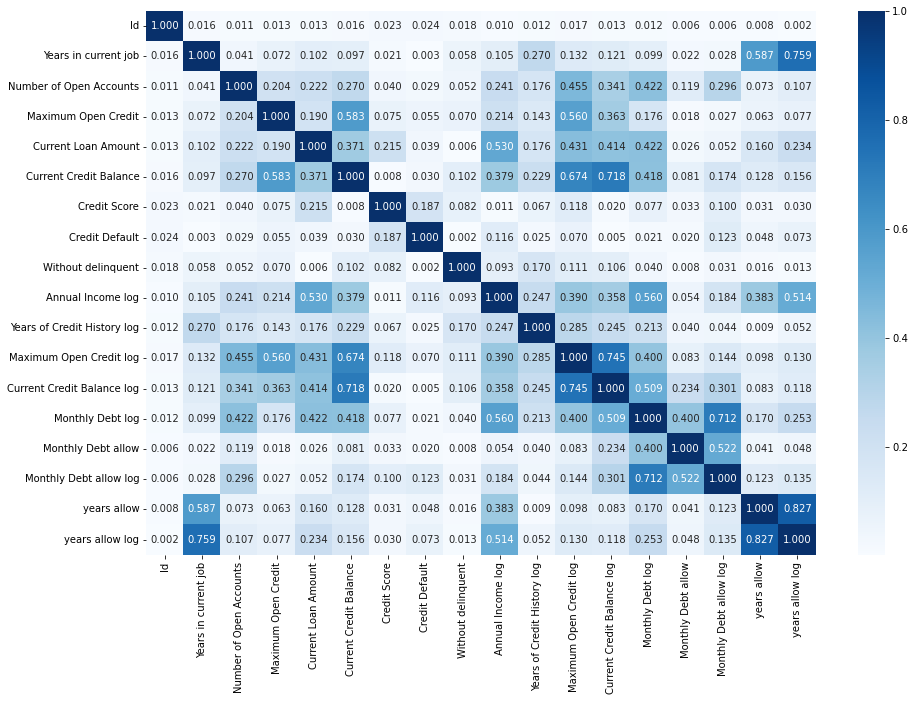

In [1472]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr().abs(), annot=True, fmt='.3f', cmap="Blues")
plt.show()

Видим, что часть признаков сильно коррелирует друг с другом удалим часть из них:
        

In [1471]:
df = df.drop(['Annual Income', 'Years of Credit History', 'Monthly Debt'], axis=1)

In [1473]:
df = df.drop(['Current Credit Balance'], axis=1)

In [1474]:
df = df.drop(['Current Credit Balance log'], axis=1)

In [1475]:
df = df.drop(['years allow'], axis=1)

In [1476]:
df = df.drop(['Years in current job'], axis=1)

In [1477]:
df = df.drop(['Monthly Debt log'], axis=1)

### Выделение новых признаков

In [1478]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'Credit Default']).to_list()
categorical_features = df.select_dtypes(include=['object']).columns.to_list()

In [1479]:
print("Categorial features:", categorical_features, "Number features:", numeric_features, sep='\n')

Categorial features:
['Home Ownership', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Open Accounts bins']
Number features:
['Number of Open Accounts', 'Maximum Open Credit', 'Current Loan Amount', 'Credit Score', 'Without delinquent', 'Annual Income log', 'Years of Credit History log', 'Maximum Open Credit log', 'Monthly Debt allow', 'Monthly Debt allow log', 'years allow log']


In [1480]:
X = df[[*categorical_features, *numeric_features]]
y = df['Credit Default']

#Выделим трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)
#Выделим отдельно трейн и валид для корректировки моделей
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=RANDOM_SEED)

#Выделим массивы без обработки для проверки доп критериев
df_train = X_train.copy()
df_test = X_test.copy()

In [1481]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)
#X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, y_train = oversample.fit_resample(X_train, y_train)

### Преобразование признаков

In [1482]:
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]
X_val_num = X_val[numeric_features]

X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]
X_val_cat = X_val[categorical_features]

#StandardScaler
#MinMaxScaler
stand_scaler = StandardScaler()
X_train_num = stand_scaler.fit_transform(X_train_num)
X_test_num = stand_scaler.transform(X_test_num)
X_val_num = stand_scaler.transform(X_val_num)

#RareLabelEncoder
rle = RareLabelEncoder(tol=0.05, n_categories=3, replace_with='Rare')
X_train_cat = rle.fit_transform(X_train_cat, y_train)
X_test_cat = rle.transform(X_test_cat)
X_val_cat = rle.transform(X_val_cat)

#WOEEncoder
woe = WOEEncoder(random_state=RANDOM_SEED)
X_train_cat = woe.fit_transform(X_train_cat, y_train)
X_test_cat = woe.transform(X_test_cat)
X_val_cat = woe.transform(X_val_cat)


# Объединим обратно категориальные и числовые датасеты
X_train = np.hstack((X_train_num, X_train_cat))
X_test = np.hstack((X_test_num, X_test_cat))
X_val = np.hstack((X_val_num, X_val_cat))

Сделать оверсэмплинг!

### PSI

In [1483]:
print("Значения PSI для числовых признаков\n")

for var in numeric_features:
    psi_var = calculate_psi(df_train[var], df_test[var])
    print(f"{var:30s}: {psi_var:.5f}")

Значения PSI для числовых признаков

Number of Open Accounts       : 0.00479
Maximum Open Credit           : 0.01067
Current Loan Amount           : 0.01295
Credit Score                  : 0.00703
Without delinquent            : 0.00061
Annual Income log             : 0.00508
Years of Credit History log   : 0.00457
Maximum Open Credit log       : 0.01269
Monthly Debt allow            : 0.00328
Monthly Debt allow log        : 0.01017
years allow log               : 0.00771


Вывод:!

## Модели

### LogisticRegression

In [1484]:
#LogisticRegression Модель без оптимизации
lr_model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
lr_prb = lr_model.predict_proba(X_test)[:, 1]
lr_val = lr_model.predict(X_test)

In [1383]:
#LogisticRegression Модель с оптимизацией гиперпараметров
lr_model = LogisticRegression(random_state=RANDOM_SEED)

param_grid = [{
    'solver': ['saga'],  
    'penalty': ['l1','l2', 'elasticnet'],
    'C': (1.0, 100, 'log-uniform'),
    'l1_ratio': (0.0, 1.0)
},
{
    'solver': ['liblinear'],  
    'penalty': ['l1','l2'],
    'C': (1.0, 100, 'log-uniform'),
    'l1_ratio': (0.0, 1.0)
}]

opt = BayesSearchCV(
    lr_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [1384]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('C', 3),
             ('l1_ratio', 0.0017807899811724819),
             ('penalty', 'l2'),
             ('solver', 'saga')])

In [1385]:
lr_model = LogisticRegression(**opt.best_params_, random_state=RANDOM_SEED).fit(X_train, y_train)
lr_prb = lr_model.predict_proba(X_test)[:, 1]

#### Feature importance

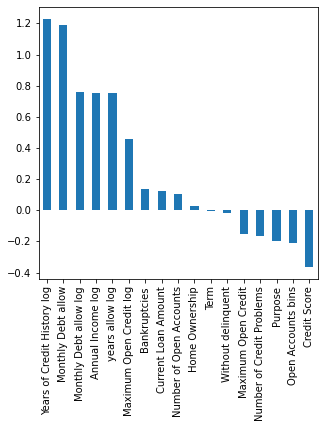

In [1485]:
#feature importance
lr_imp = pd.Series(lr_model.coef_[0], index=df_train.columns)

plt.figure(figsize=(5,5))
lr_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

#### roc_auc и ROC curve

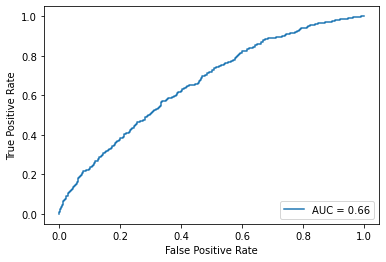

In [1486]:
#roc_auc и ROC curve

fpr, tpr, threshold = roc_curve(y_test, lr_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

#### Индекс Джини и интервальный Джини

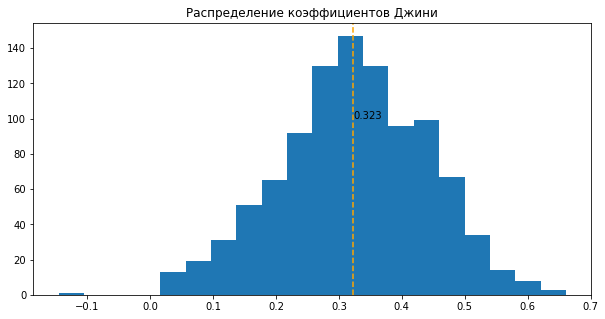

In [1487]:
# Коэффициент Джини и интервальный Джини
#gini_interv = interval_gini_old(lr_prb) #это некорректный джини
gini_x = round(2*roc_auc_score(y_test, lr_prb) - 1, 3)
gini_interv = interval_gini(y_test, lr_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

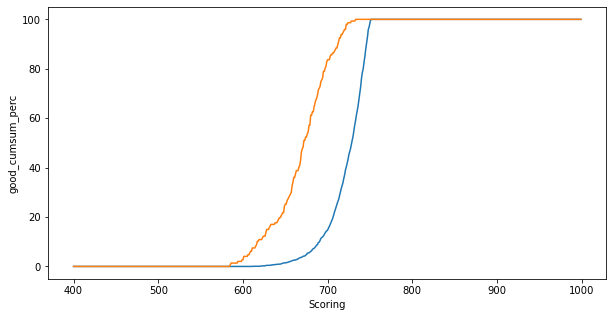

KstestResult(statistic=0.12333333333333334, pvalue=0.0002140845532836797)

In [1331]:
model_ks_test(lr_prb, df_test)

#### Изотоническая калибровка и график сравнения

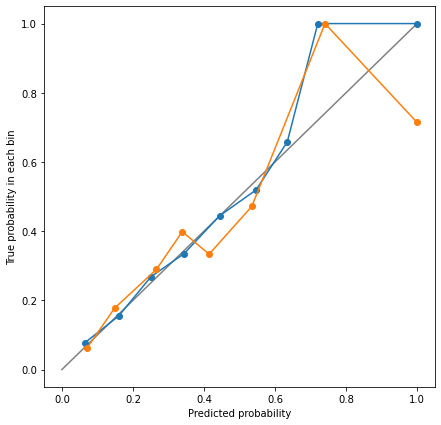

In [1332]:
model_calibr_curve(lr_model, lr_prb, y_test, X_val, y_val)

### SVM модель

In [1376]:
#SVM Модель без оптимизации
svc_model = SVC(probability=True, random_state=RANDOM_SEED).fit(X_train, y_train)
svc_prb = svc_model.predict_proba(X_test)[:, 1]

In [99]:
#SVM Модель с оптимизацией гиперпараметров
svc_model = SVC(probability=True, random_state=RANDOM_SEED)

param_grid = {
    'C': (1e-6, 100.0, 'log-uniform'),
    'degree': (1, 5),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}


opt = BayesSearchCV(
    svc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [102]:
opt.fit(X_train, y_train)
opt.best_params_

Замечание: Оптимизация для данного алгоритма гораздо дольше чем logisticregression

In [105]:
svc_model = SVC(**opt.best_params_, probability=True, random_state=RANDOM_SEED).fit(X_train, y_train)
svc_prb = svc_model.predict_proba(X_test)[:, 1]

#### Feature importance

In [1377]:
#feature importance
if svc_model.kernel == 'linear':
    svc_imp = pd.Series(svc_model.coef_, index=df_train.columns)

    plt.figure(figsize=(5,5))
    svc_imp.sort_values(ascending=False).plot.bar()
    plt.show()
else:
    print("Feature importance works only for SVM with linear kernel")

Feature importance works only for SVM with linear kernel


#### Оценка качества модели

#### roc_auc и ROC curve

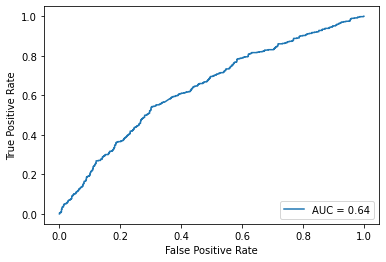

In [1378]:
#roc_auc и ROC curve

fpr, tpr, threshold = roc_curve(y_test, svc_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

#### Коэффициент Джини и интервальный Джини

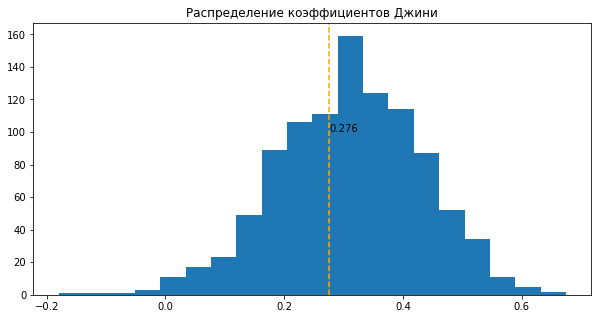

In [1379]:
# Коэффициент Джини и интервальный Джини
#gini_interv = interval_gini_old(svc_prb) #это некорректный джини
gini_x = round(2*roc_auc_score(y_test, svc_prb) - 1, 3)
gini_interv = interval_gini(y_test, svc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

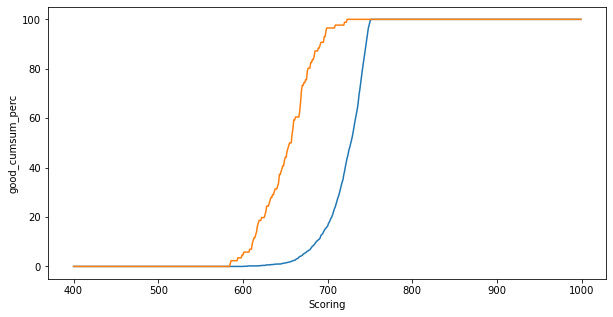

KstestResult(statistic=0.14, pvalue=1.5177728391901887e-05)

In [809]:
model_ks_test(svc_prb, df_test)

#### Изотоническая калибровка и график сравнения

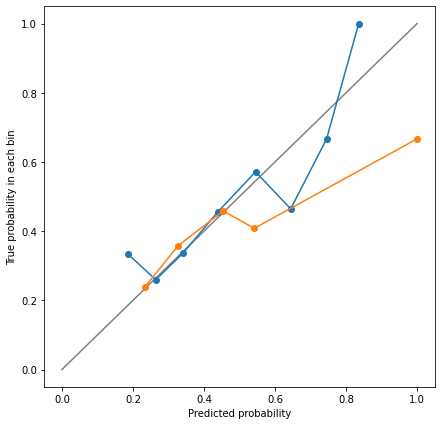

In [827]:
model_calibr_curve(svc_model, svc_prb, y_test, X_val, y_val)

### Random Forest

In [453]:
#RandomForestClassifier Модель без оптимизации
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train)
rfc_prb = rfc_model.predict_proba(X_test)[:, 1]

In [116]:
#RandomForestClassifier Модель с оптимизацией гиперпараметров
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED)

param_grid = {
        'n_estimators': (5,500),
        'max_features': ['auto','sqrt', 'log2', None],
        'max_depth': (2,100),
        'min_samples_split': (2,10)
}

opt = BayesSearchCV(
    rfc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [118]:
opt.fit(X_train, y_train)
opt.best_params_

In [85]:
rfc_model = RandomForestClassifier(**opt.best_params_, random_state=RANDOM_SEED).fit(X_train, y_train)
rfc_prb = rfc_model.predict_proba(X_test)[:, 1]

#### Feature importance Gini

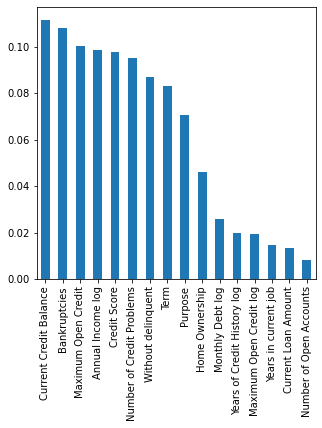

In [454]:
#Gini importance
rfc_imp = pd.Series(rfc_model.feature_importances_, index=df_train.columns)

plt.figure(figsize=(5,5))
rfc_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

#### roc_auc и ROC curve

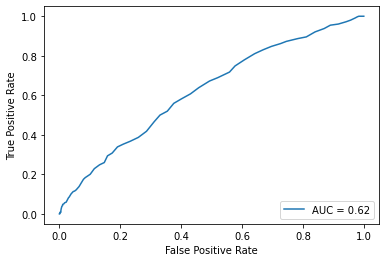

In [455]:
#roc_auc и ROC curve

fpr, tpr, threshold = roc_curve(y_test, rfc_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

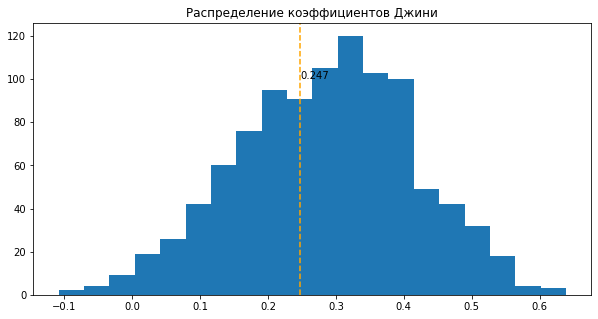

In [456]:
#### Индекс Джини и интервальный Джини

# Коэффициент Джини и интервальный Джини
#gini_interv = interval_gini_old(lr_prb) #это некорректный джини

gini_x = round(2*roc_auc_score(y_test, rfc_prb) - 1, 3)
gini_interv = interval_gini(y_test, rfc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

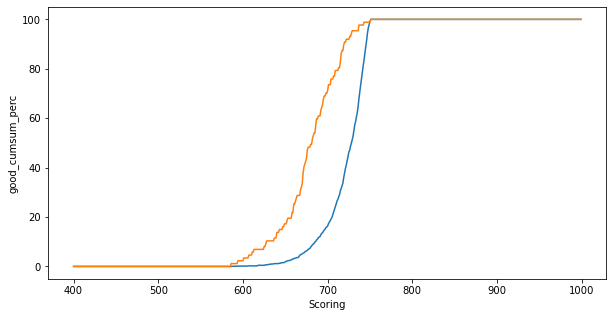

KstestResult(statistic=0.10666666666666667, pvalue=0.002153187784766389)

In [457]:
model_ks_test(rfc_prb, df_test)

#### Изотоническая калибровка и график сравнения

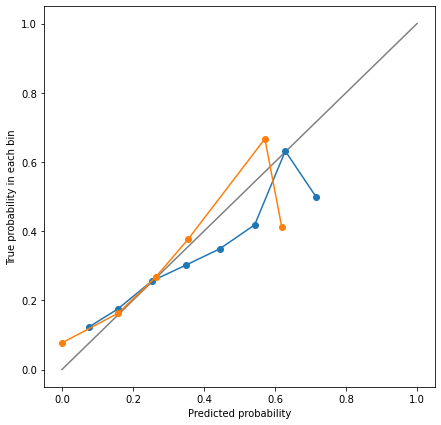

In [458]:
model_calibr_curve(rfc_model, rfc_prb, y_test, X_val, y_val)

### LGBMClassifier

In [1380]:
#LGBMClassifier Модель без оптимизации
lgbmc_model = LGBMClassifier(importance_type='gain', random_state=RANDOM_SEED).fit(X_train, y_train)
lgbmc_prb = lgbmc_model.predict_proba(X_test)[:, 1]

In [152]:
#LGBMClassifier Модель с оптимизацией гиперпараметров
lgbmc_model = LGBMClassifier(importance_type='gain', random_state=RANDOM_SEED)

param_grid = {
        'n_estimators': (10, 500),
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (2, 100),
        'reg_alpha': (0, 10),
        'reg_lambda': (0, 100)
}

opt = BayesSearchCV(
    lgbmc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [153]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('learning_rate', 0.02160217783087772),
             ('max_depth', 92),
             ('n_estimators', 61),
             ('reg_alpha', 4),
             ('reg_lambda', 19)])

In [155]:
lgbmc_model = LGBMClassifier(**opt.best_params_, importance_type='gain', random_state=RANDOM_SEED).fit(X_train, y_train)
lgbmc_prb = lgbmc_model.predict_proba(X_test)[:, 1]

#### Feature importance Gain (Gini)

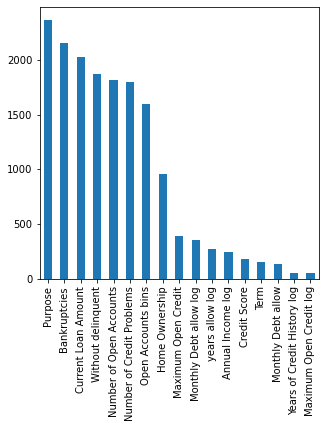

In [1381]:
lgbmc_imp = pd.Series(lgbmc_model.feature_importances_, index=df_train.columns)

plt.figure(figsize=(5,5))
lgbmc_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

#### roc_auc и ROC curve

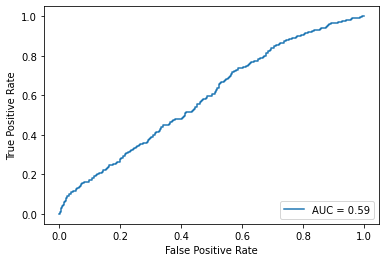

In [1382]:
#roc_auc и ROC curve

fpr, tpr, threshold = roc_curve(y_test, lgbmc_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

#### Коэффициент Джини и интервальный Джини

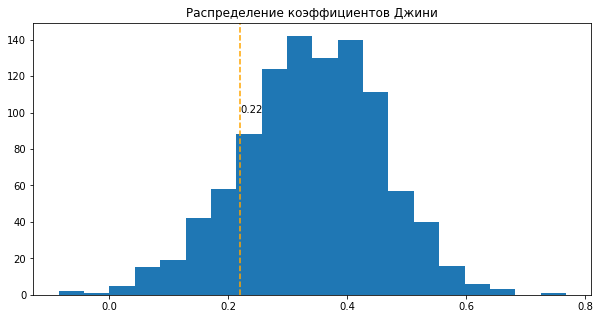

In [279]:
# Коэффициент Джини и интервальный Джини
#gini_interv = interval_gini_old(svc_prb) #это некорректный джини

gini_x = round(2*roc_auc_score(y_test, lgbmc_prb) - 1, 3)
gini_interv = interval_gini(y_test, lgbmc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

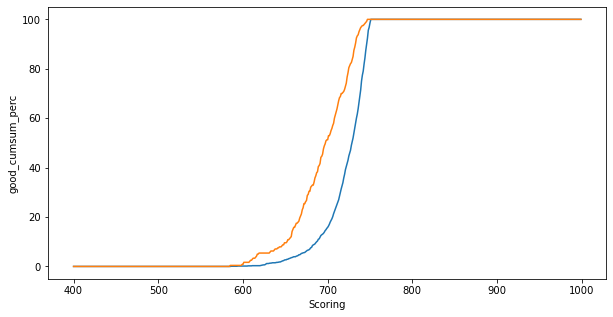

KstestResult(statistic=0.08666666666666667, pvalue=0.02202864112829929)

In [280]:
model_ks_test(lgbmc_prb, df_test)

#### Изотоническая калибровка и график сравнения

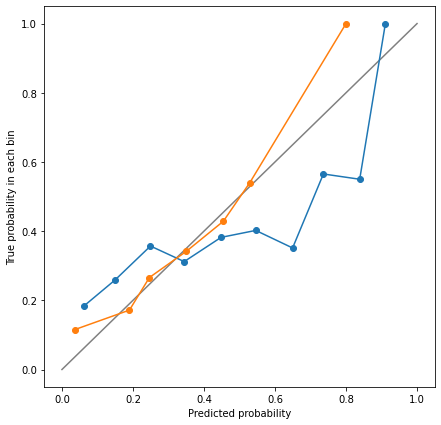

In [281]:
model_calibr_curve(lgbmc_model, lgbmc_prb, y_test, X_val, y_val)